In [1]:
!pip install transformers datasets sklearn accelerate -U


  Using cached transformers-4.39.3-py3-none-any.whl (8.8 MB)
  Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load and prepare your dataset
df = pd.read_csv('/content/NFR_CSV.csv')

# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2)


In [3]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def encode_sentences(sentences):
    return tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = encode_sentences(train_df['sentence'].tolist())
test_encodings = encode_sentences(test_df['sentence'].tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['class_name'])
test_labels = label_encoder.transform(test_df['class_name'])


In [5]:
class NFRDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NFRDataset(train_encodings, train_labels)
test_dataset = NFRDataset(test_encodings, test_labels)


In [6]:
pip install transformers[torch]

In [7]:
!pip install accelerate -U


In [8]:
!pip install accelerate>=0.21.0 -U


In [9]:
import accelerate
print(accelerate.__version__)


0.29.2


In [10]:
# num_labels = len(label_encoder.classes_)  # This is equivalent to df['class_name'].nunique()

# model = RobertaForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=num_labels)


In [11]:
# roberta
num_labels = len(label_encoder.classes_)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
pip install  torch sklearn pandas matplotlib seaborn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [13]:
import torch


In [14]:

from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Training the model
trainer.train()

# Evaluating the model
evaluation_results = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# # Prepare metrics for CSV and printing
# metrics = {
#     "Precision": evaluation_results['eval_precision'],
#     "Recall": evaluation_results['eval_recall'],
#     "F1 Score": evaluation_results['eval_f1']
# }

# # Writing metrics to CSV
# metrics_filename = 'evaluation_metrics.csv'
# with open(metrics_filename, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["Metric", "Value"])
#     for key, value in metrics.items():
#         writer.writerow([key, value])

# # Printing metrics
# for metric, value in metrics.items():
#     print(f"{metric}: {value}")

# # Evaluating the model
# evaluation_results = trainer.evaluate()
print(evaluation_results)

{'eval_loss': 0.8382731676101685, 'eval_precision': 0.800972351605263, 'eval_recall': 0.7777777777777778, 'eval_f1': 0.7517960665601457, 'eval_runtime': 45.3864, 'eval_samples_per_second': 4.164, 'eval_steps_per_second': 0.529, 'epoch': 3.0}


In [16]:
# # def predict(sentence):
# #     inputs = tokenizer(sentence, padding=True, truncation=True, max_length=128, return_tensors="pt")
# #     outputs = model(**inputs)
# #     predictions = torch.argmax(outputs.logits, dim=1)
# #     return label_encoder.inverse_transform(predictions.numpy())[0]

# # # Example usage
# # print(predict("Software should easy to use."))

# def predict():
#     # Prompt the user to enter a sentence
#     sentence = input("Enter a sentence to classify: ")
#     inputs = tokenizer(sentence, padding=True, truncation=True, max_length=128, return_tensors="pt")
#     outputs = model(**inputs)
#     predictions = torch.argmax(outputs.logits, dim=1)
#     # Return the predicted class name
#     return label_encoder.inverse_transform(predictions.numpy())[0]

# # Call the predict function which now includes a user prompt
# print(predict())



In [17]:
# def predict(sentence):
#     inputs = tokenizer(sentence, padding=True, truncation=True, max_length=128, return_tensors="pt")
#     outputs = model(**inputs)
#     predictions = torch.argmax(outputs.logits, dim=1)
#     return label_encoder.inverse_transform(predictions.numpy())[0]

# # Example usage
# print(predict("Software should easy to use."))

def predict():
    # Prompt the user to enter a sentence
    sentence = input("Enter a sentence to classify: ")
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    scores = torch.softmax(logits, dim=1).numpy()[0]  # Convert logits to probabilities

    # Print prediction scores for each class
    print("Prediction scores:")
    for score, label in zip(scores, label_encoder.classes_):
        print(f"{label}: {score:.4f}")

    # Get the predicted class index
    predicted_index = np.argmax(scores)

    # Retrieve the predicted class name
    predicted_class_name = label_encoder.inverse_transform([predicted_index])[0]

    print("Predicted class:", predicted_class_name)

# Call the predict function to test
predict()

Enter a sentence to classify: software should be easy to use.
Prediction scores:
Fault Tolerance: 0.0031
Maintainability: 0.0035
Operability: 0.0023
Performance: 0.0034
Portability: 0.0019
Scalability: 0.0032
Security: 0.0023
Usability: 0.9802
Predicted class: Usability


In [18]:
print(label_encoder.classes_)

['Fault Tolerance' 'Maintainability' 'Operability' 'Performance'
 'Portability' 'Scalability' 'Security' 'Usability']


#Confusion matrices

In [19]:
# Predict on the evaluation dataset
predictions = trainer.predict(test_dataset)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Extract the predicted labels
preds = np.argmax(predictions.predictions, axis=1)

# True labels are part of the predictions object
labels = predictions.label_ids


In [21]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for each class
cm = confusion_matrix(labels, preds)


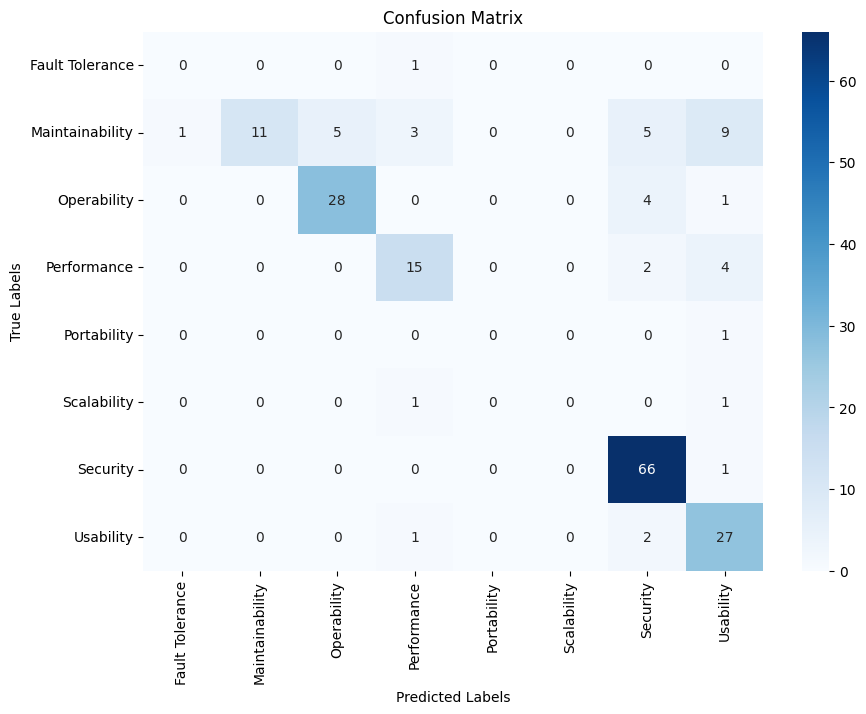

In [22]:
def plot_confusion_matrix(cm, class_names, figsize=(10, 7)):
    # Plotting the confusion matrix as a heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=90)
    plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=0)
    plt.title('Confusion Matrix')
    plt.show()

# Get the class names from the label encoder
class_names = label_encoder.classes_

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix


In [24]:
# Calculate the multilabel confusion matrix
cm = multilabel_confusion_matrix(labels, preds)


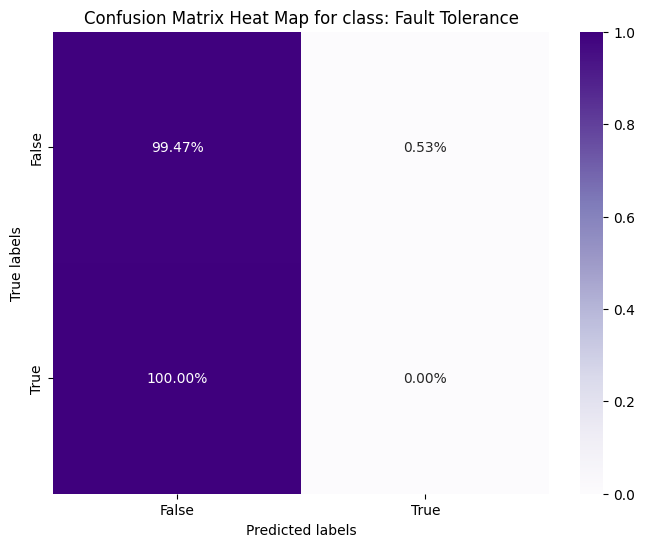

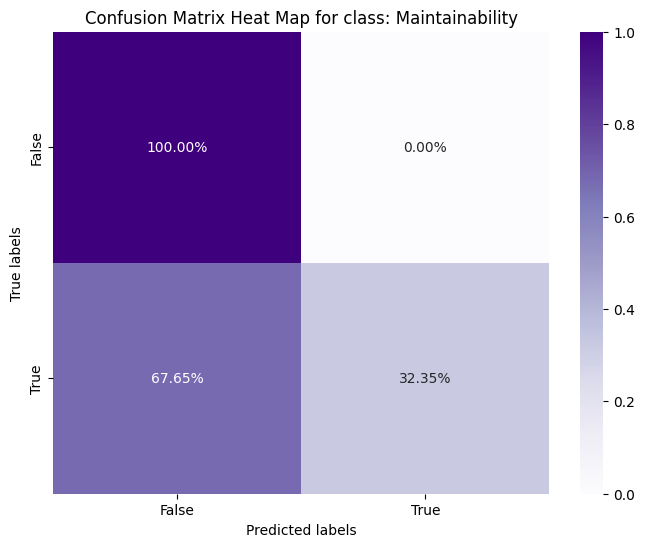

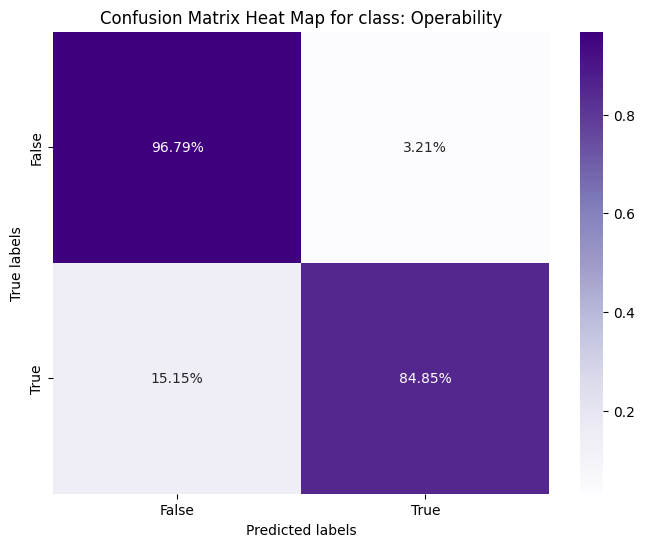

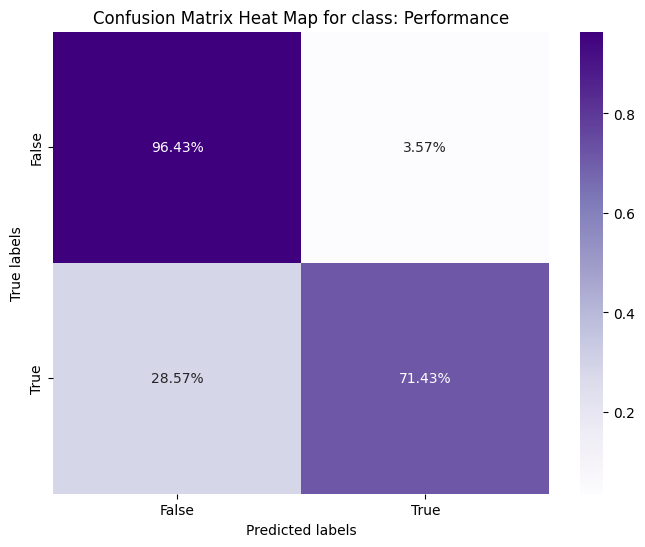

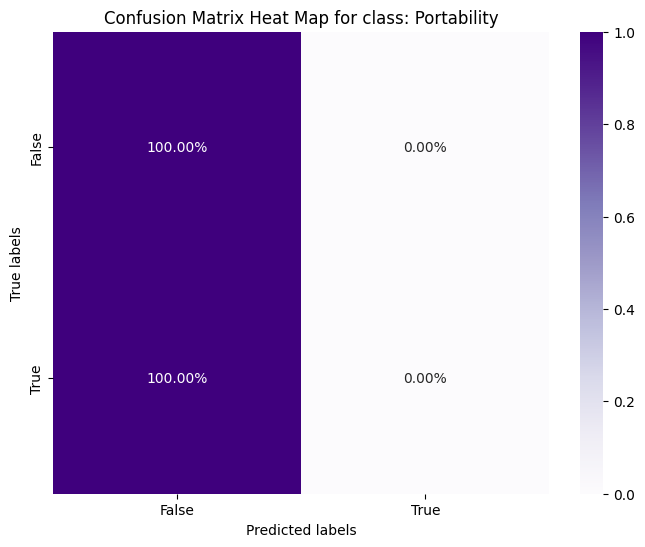

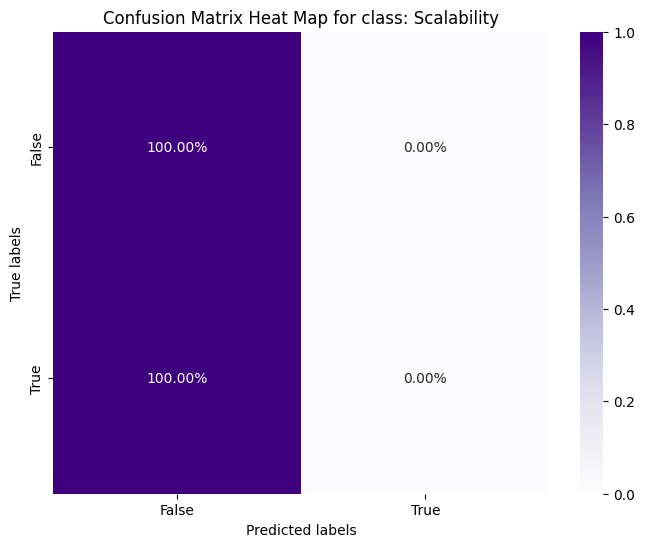

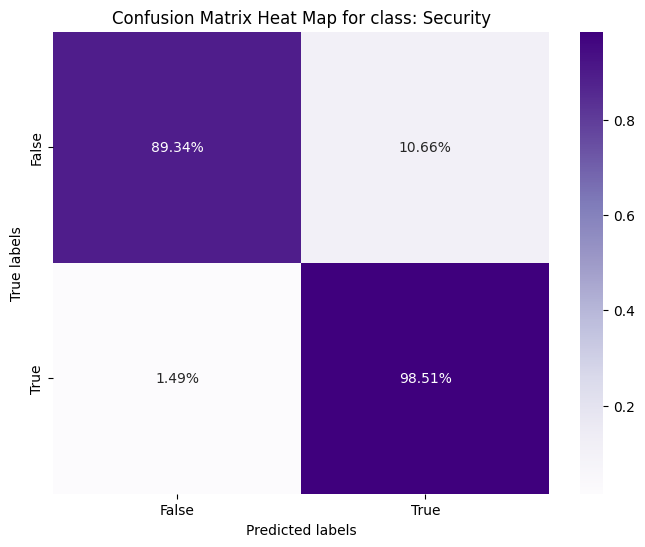

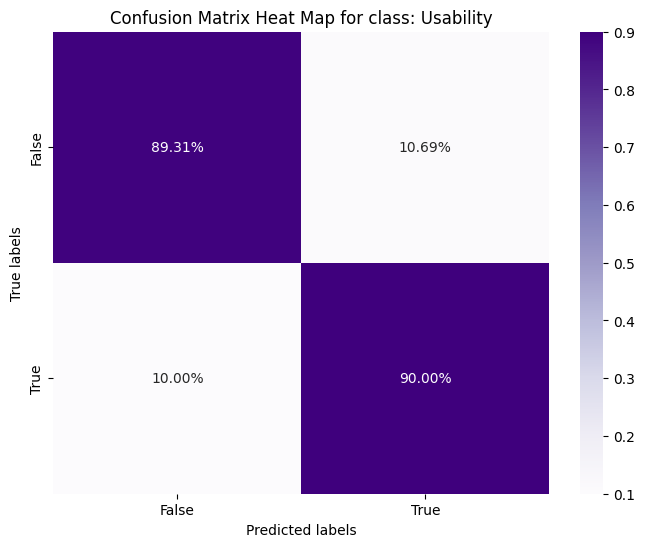

In [27]:
def plot_confusion_matrix_per_class(cm, class_names):
    for i, matrix in enumerate(cm):
        # Calculate percentage for each section in the confusion matrix
        cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0

        # Plotting the heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Purples')

        # Setting the labels and titles
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Confusion Matrix Heat Map for class: {class_names[i]}')
        plt.xticks(ticks=[0.5, 1.5], labels=['False', 'True'])
        plt.yticks(ticks=[0.5, 1.5], labels=['False', 'True'])
        plt.show()

# Class names for your dataset
class_names = label_encoder.classes_  # Make sure label_encoder is fitted with class names

# Assuming cm and class_names are already defined
plot_confusion_matrix_per_class(cm, class_names)
